In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.leaguehustlestatsteam import LeagueHustleStatsTeam
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats

In [4]:
df = pd.read_csv('pbp_data/2021-22.csv')

In [5]:
full_df = pd.read_csv('pbp_data/2021-22.csv')

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [6]:
full_df.loc[(full_df.EVENTMSGTYPE == 6) & (full_df.PLAYER2_NAME == 'Chris Paul'), ['EVENTMSGACTIONTYPE', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'PLAYER1_NAME', 'PLAYER2_NAME']]

,EVENTMSGACTIONTYPE,HOMEDESCRIPTION,VISITORDESCRIPTION,PLAYER1_NAME,PLAYER2_NAME
7897,1,,Hardaway Jr. P.FOUL (P1.T1) (K.Cutler),Tim Hardaway Jr.,Chris Paul
8026,2,,Burke S.FOUL (P1.T1) (E.Scott),Trey Burke,Chris Paul
8274,1,,Finney-Smith P.FOUL (P2.T2) (B.Kennedy),Dorian Finney-Smith,Chris Paul
14705,1,,Hardaway Jr. P.FOUL (P2.T2) (T.Maddox),Tim Hardaway Jr.,Chris Paul
14862,2,,Bullock S.FOUL (P2.PN) (P.Fraher),Reggie Bullock,Chris Paul
14961,2,,Bullock S.FOUL (P3.T4) (S.Wall),Reggie Bullock,Chris Paul
20982,3,Vanderbilt L.B.FOUL (P2.T3) (J.Capers),,Jarred Vanderbilt,Chris Paul
21110,1,Beverley P.FOUL (P1.T3) (A.Smith),,Patrick Beverley,Chris Paul
21198,1,Vanderbilt P.FOUL (P4.T1) (J.Capers),,Jarred Vanderbilt,Chris Paul
21235,2,Beverley S.FOUL (P4.T4) (A.Smith),,Patrick Beverley,Chris Paul


In [7]:
 full_df.loc[(full_df.EVENTMSGTYPE == 6) &  ((full_df.HOMEDESCRIPTION.str.contains('.PN')) | (full_df.VISITORDESCRIPTION.str.contains('.PN'))), ['EVENTMSGACTIONTYPE', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'PLAYER1_NAME', 'PLAYER2_NAME']].EVENTMSGACTIONTYPE.unique()

array([ 1,  2, 28,  3, 11, 14,  9,  6, 15], dtype=int64)

In [8]:
penalty_fouls = full_df.loc[(full_df.EVENTMSGTYPE == 6) & (full_df.EVENTMSGACTIONTYPE == 1) & ((full_df.HOMEDESCRIPTION.str.contains('.PN')) | (full_df.VISITORDESCRIPTION.str.contains('.PN')))]

In [9]:
fouls_df = penalty_fouls.groupby(['PLAYER2_ID', 'PLAYER2_NAME']).size().reset_index().rename(columns={0: 'FOULS_DRAWN_REGULAR_PENALTY'})

In [10]:
top_players = fouls_df.sort_values(by='FOULS_DRAWN_REGULAR_PENALTY', ascending=False).iloc[:15]

In [11]:
plt.style.use('fivethirtyeight')

In [12]:
from matplotlib.patches import Rectangle

In [13]:
all_fouls = full_df.loc[full_df.EVENTMSGTYPE == 6]

In [14]:
total_fouls_drawn = all_fouls.groupby(['PLAYER2_ID', 'PLAYER2_NAME']).size().reset_index().rename(columns={0: 'FOULS_DRAWN'})

In [15]:
regular_personal_fouls = full_df.loc[(full_df.EVENTMSGTYPE == 6) & (full_df.EVENTMSGACTIONTYPE == 1)]

In [16]:
total_regular_fouls_drawn = regular_personal_fouls.groupby(['PLAYER2_ID', 'PLAYER2_NAME']).size().reset_index().rename(columns={0: 'FOULS_DRAWN_REGULAR'})

In [17]:
merged_df = pd.merge(left=total_fouls_drawn, right=fouls_df, on=['PLAYER2_ID', 'PLAYER2_NAME'])

In [18]:
merged_df = pd.merge(left=merged_df, right=total_regular_fouls_drawn, on=['PLAYER2_ID', 'PLAYER2_NAME'])

In [19]:
top_players = merged_df.sort_values(by='FOULS_DRAWN_REGULAR_PENALTY', ascending=False).iloc[:15]

In [20]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.125

player_root_dir = f'player_imgs/'
team_root_dir = f'../../team_logos_id/'

def get_player_img(player_id, zoom=0.55):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id, zoom=zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [21]:
top_players

,PLAYER2_ID,PLAYER2_NAME,FOULS_DRAWN,FOULS_DRAWN_REGULAR_PENALTY,FOULS_DRAWN_REGULAR
265,1629027,Trae Young,429,83,200
132,203999,Nikola Jokic,473,58,231
129,203954,Joel Embiid,554,51,165
5,101108,Chris Paul,202,46,120
13,201142,Kevin Durant,297,42,127
267,1629029,Luka Doncic,382,39,153
126,203944,Julius Randle,334,39,128
141,1626156,D'Angelo Russell,213,35,106
103,203497,Rudy Gobert,352,35,134
153,1626174,Christian Wood,316,34,139


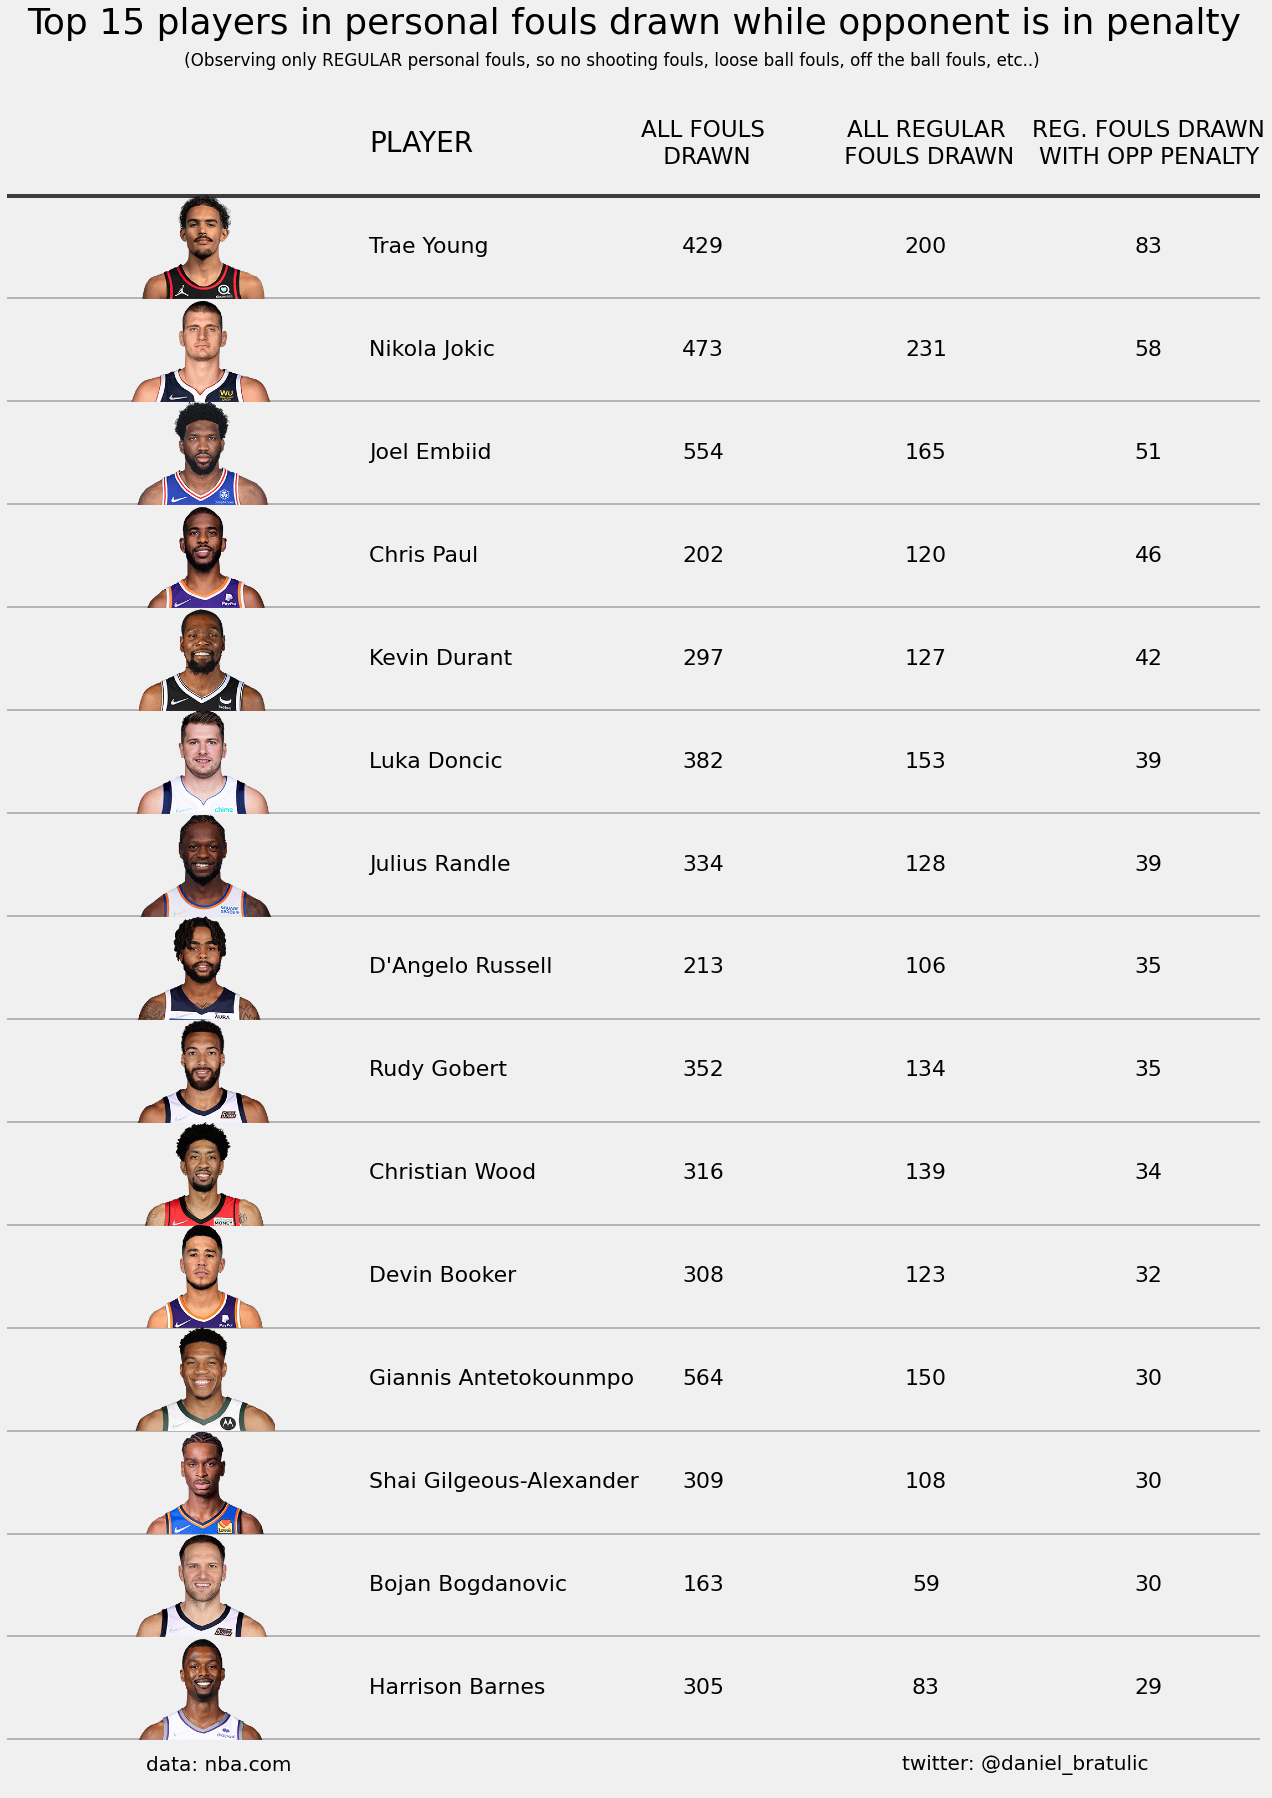

In [22]:
fig, ax = plt.subplots(figsize=(20, 30))
font_size = 22
font_title = 28
top = len(top_players)
#top = 10

for i in range(top):
    item = top_players.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        #rect = Rectangle((-0.5, y_coord + 0.5), width=5, height=1, fill=True, color=color)
        #ax.add_patch(rect)
    ab = AnnotationBbox(get_player_img(item.PLAYER2_ID), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.4, y=y_coord, ha='left', va='center', s=item.PLAYER2_NAME, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.0, y=y_coord, ha='center', va='center', s=item.FOULS_DRAWN, size=font_size)
    ax.text(x=1.4, y=y_coord, ha='center', va='center', s=item.FOULS_DRAWN_REGULAR, size=font_size)
    ax.text(x=1.8, y=y_coord, ha='center', va='center', s=item.FOULS_DRAWN_REGULAR_PENALTY, size=font_size)
    #ax.text(x=4, y=y_coord, ha='center', va='center', s=f"{item.SVI:.2f}", size=font_size)
    
    
    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_igms[item.TEAM_ID], extent=(2.3, 2.5, y_coord-0.35,y_coord + 0.35), aspect='auto', zorder=1)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.5, y=top, ha='center', va='center', s="TEAM", size=font_title)    
ax.text(x=0.4, y=top, s='PLAYER', ha='left', va='center', size=font_title)
ax.text(x=1.0, y=top, ha='center', va='center', s="ALL FOULS\n DRAWN", size=font_title-5)
ax.text(x=1.4, y=top, ha='center', va='center', s="ALL REGULAR\n FOULS DRAWN", size=font_title-5)
ax.text(x=1.8, y=top, ha='center', va='center', s="REG. FOULS DRAWN\nWITH OPP PENALTY", size=font_title-5)
#ax.text(x=1.8, y=top, ha='center', va='center', s="FOULS DRAWN\nWITH OPP PENALTY", size=font_title)
#ax.text(x=3.2, y=top, ha='center', va='center', s="MIN", size=font_title)
#ax.text(x=3.6, y=top, s='PPG', ha='center', va='center', size=font_title)
#ax.text(x=4, y=top, s='SVI', ha='center', va='center', size=font_title)

ax.text(x=1.8, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=20)
ax.text(x=0, y=-0.75, s='data: nba.com', ha='left', va='center', size=20)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top 15 players in personal fouls drawn while opponent is in penalty", size=36)
plt.suptitle("(Observing only REGULAR personal fouls, so no shooting fouls, loose ball fouls, off the ball fouls, etc..)", y=0.875)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0.25, right=2.0)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('slika.png', dpi=120, bbox_inches='tight')

In [23]:
merged_df.sort_values(by='FOULS_DRAWN_REGULAR_PENALTY', ascending=False).iloc[:35]

,PLAYER2_ID,PLAYER2_NAME,FOULS_DRAWN,FOULS_DRAWN_REGULAR_PENALTY,FOULS_DRAWN_REGULAR
265,1629027,Trae Young,429,83,200
132,203999,Nikola Jokic,473,58,231
129,203954,Joel Embiid,554,51,165
5,101108,Chris Paul,202,46,120
13,201142,Kevin Durant,297,42,127
267,1629029,Luka Doncic,382,39,153
126,203944,Julius Randle,334,39,128
141,1626156,D'Angelo Russell,213,35,106
103,203497,Rudy Gobert,352,35,134
153,1626174,Christian Wood,316,34,139
